In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1
device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
import math
from continous_diffusion.diffusion import Diffusion
from continous_diffusion.model import DiffusionTransformer
from continous_diffusion.loss import Loss
from continous_diffusion.embedding import Embedder
from continous_diffusion.scheduling import CauchySchedule, LogisticSchedule
from continous_diffusion.conditioning import TimeConditioning

embed_dim=128
qkv_dim=1024
num_heads=8
cond_dim=16
n_blocks=8

dit=DiffusionTransformer(embed_dim,qkv_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,200,0,0.3,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
model=Diffusion(dit,loss).to(device)

print(model.n_parameters)

4461088


In [3]:
# DataLoader
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR, ExponentialLR

train_loader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

warmup=LinearLR(optimizer,1e-3,1,5)
decay=ExponentialLR(optimizer,gamma=0.9)
scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[6])

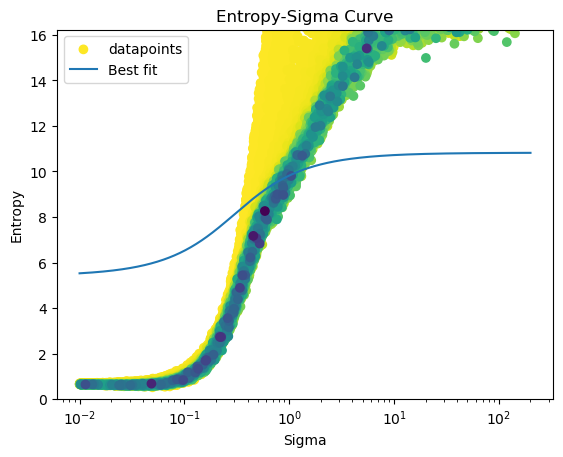

lr: [3.090315438263264e-06]
Step: 1950,  Loss: 5.344574928283691
Step: 1951,  Loss: 5.477648735046387
Step: 1952,  Loss: 5.337827682495117
Step: 1953,  Loss: 4.518488883972168
Step: 1954,  Loss: 4.404561996459961
Step: 1955,  Loss: 5.7015228271484375
Step: 1956,  Loss: 5.839259624481201
Step: 1957,  Loss: 4.5118021965026855
Step: 1958,  Loss: 5.038928031921387
Step: 1959,  Loss: 5.522195339202881
Step: 1960,  Loss: 4.570176124572754
Step: 1961,  Loss: 4.865183353424072
Step: 1962,  Loss: 5.162693977355957
Step: 1963,  Loss: 5.11707878112793
Step: 1964,  Loss: 6.583745956420898
Step: 1965,  Loss: 4.831056594848633
Step: 1966,  Loss: 6.487289905548096
Step: 1967,  Loss: 3.8721232414245605
Step: 1968,  Loss: 7.775379180908203
Step: 1969,  Loss: 4.104741096496582
Step: 1970,  Loss: 6.148377895355225
Step: 1971,  Loss: 5.24442195892334
Step: 1972,  Loss: 4.697608947753906
Step: 1973,  Loss: 5.002532482147217
Step: 1974,  Loss: 5.004443168640137
Step: 1975,  Loss: 5.515794277191162
Step: 197

2024-03-22 07:27:10,250 - INFO - Updated optimal parameters: mu=3.9408795130144027e-16, sigma=0.6392614777779324, height=33.26383304924005, offset=-17.112004537013828


In [4]:
schedule_update_frequency=2000

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  # Define your optimizer
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            schedule.update_optimal_parameters()

        if i%50==0 and i!=0:
            scheduler.step()
            clear_output(wait=True) 
            schedule.plot_entropy_time_curve()
            print(f"lr: {scheduler.get_last_lr()}")


        print(f"Step: {i},  Loss: {loss.item()}")


In [ ]:
out=model.generate(1,64,1000,device=device)
out=model.un_embedder(out)
sampler=torch.distributions.Categorical(logits=out)
sample=sampler.sample().tolist()
tokenizer.batch_decode(sample)

100%|██████████| 999/999 [00:06<00:00, 157.86it/s]


[' Min buildingaux dotted Dance Strike declaring Doing pilots399 implements outsidersarna HearthBack Ball magrust led exasper Some Grounds 1966 recognizeWal ambul cells routed Bruce announcements node InterPUT Micha essentially agentsmoil Ident Slow rows stockedSaid clan MoonsspellRu UnlikeChan month Electronics neck insistence Lei Will conserve steps QWMHeatsoftpediaimportCompar wants']

In [ ]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.3114,  0.1103,  2.9068, -0.4341])

In [ ]:
model.n_parameters

712192